In [1]:
import sys
import cPickle as pickle
import gzip
import json
import datetime as dt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors

sys.path.append("../utils/")
from Histogram import *

In [2]:
## Load in pitch data dataframes from pre-saved pickles

fins = [
     "../output_fromJSON/pitches_2014.pkl.gz",
     "../output_fromJSON/pitches_2015.pkl.gz",
     "../output_fromJSON/pitches_2016.pkl.gz",
     "../output_fromJSON/pitches_2017.pkl.gz",
     "../output_fromJSON/pitches_2018.pkl.gz",
     "../output_fromJSON/pitches_2019.pkl.gz",
]
dfs = []
for fin in fins:
    dfs.append(pd.read_pickle(fin, compression="gzip"))
df = pd.concat(dfs, ignore_index=True)

print "shape:", df.shape

shape: (4363258, 66)


### Select rows with unique states
* Add rows for season and score diff from present pitch to end of inning
* Save all rows with unique (game, inning, base_state, out, score) states
* Remove bottom halves of innings >=9, since they may not be complete

In [3]:
df["year"] = df.date.apply(lambda x:x.year)
df["sdiff"] = (df.half=='top')*(df.away_score_afterInn - df.away_score) + \
              (df.half=='bottom')*(df.home_score_afterInn - df.home_score)

# grab all unique game states
subset = df[["year", "gamePk", "inning", "half", "base_state", "outs", "away_score", 
             "home_score", "away_score_afterInn", "home_score_afterInn", "sdiff"]
            ].drop_duplicates()

subset = subset.query("inning<9 | half=='top'")
subset = subset.query("away_score_afterInn>=away_score & home_score_afterInn>=home_score")
#subset = subset.loc[(subset.date.apply(lambda x:x.month) == 4) & (subset.date.apply(lambda x:x.day) == 6)]
#subset = subset.query("gamePk==491288")
print subset.shape
subset.head(10)
#df.query("gamePk==490142 & inning==4 & half=='bottom'")[["inning","half","batter","balls","strikes","outs","away_score","home_score","base_state","runner_first","runner_second","event"]]
#subset.gamePk.value_counts()

(1111873, 11)


,year,gamePk,inning,half,base_state,outs,away_score,home_score,away_score_afterInn,home_score_afterInn,sdiff
0,2014,380537,1,top,0,0,0,0,0,0,0
3,2014,380537,1,top,0,1,0,0,0,0,0
8,2014,380537,1,top,0,2,0,0,0,0,0
13,2014,380537,1,bottom,0,0,0,0,0,0,0
16,2014,380537,1,bottom,0,1,0,0,0,0,0
20,2014,380537,1,bottom,1,1,0,0,0,0,0
22,2014,380537,1,bottom,3,1,0,0,0,0,0
25,2014,380537,1,bottom,6,2,0,0,0,0,0
29,2014,380537,2,top,0,0,0,0,1,0,1
33,2014,380537,2,top,1,0,0,0,1,0,1


### Histogram the number of runs scored between present pitch and end of inning
* Divide histograms based on (base_state, outs) states
* The mean of each histogram is the "run expectancy" of that particular base,out state

In [17]:
group = subset.groupby(['base_state','outs'])
YEAR_GROUPS = [(2014,),(2015,),(2017,),(2018,),(2019,),(2017,2019),(2014,2019)]
hists = {}
for yg in YEAR_GROUPS:
    hists[yg] = {}
    years = list(range(yg[0],yg[-1]+1))
    for g,idxs in group.groups.items():
        hists[yg][g] = Histogram1D("h_{0}_{1}".format(*g), 15, 0, 15, title=";runs")
        for d in subset.loc[idxs].loc[subset.year.isin(years)].sdiff.values:
            hists[yg][g].Fill(d)
        hists[yg][g].Normalize()

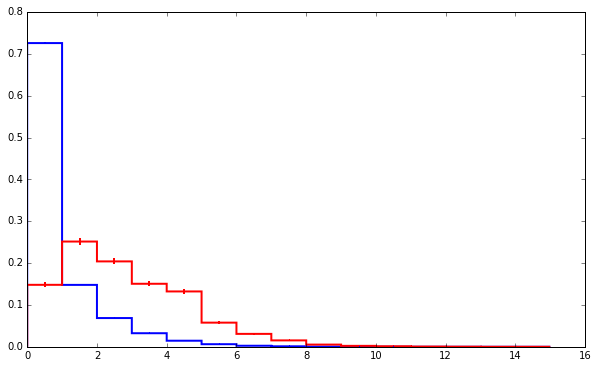

In [5]:
yg = (2014,2019)
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.set_yscale('linear')
hists[yg][(0,0)].Draw(fig, ax, "HIST YERR", color='b', lw=2)
hists[yg][(7,0)].Draw(fig, ax, "HIST YERR", color='r', lw=2)

In [6]:
print "{0:3s} {1:>7s} {2:>7s} {3:>7s}".format("", "0 out", "1 out", "2 outs")
for bs in range(8):
    s = ""
    for i in range(3):
        s += str(i+1) if bs&(1<<i) else "-"
    probs = []
    for o in range(3):
        probs.append(hists[yg][(bs,o)].mean())
    print "{0:3s} {1:7.3f} {2:7.3f} {3:7.3f}".format(s, *probs)

      0 out   1 out  2 outs
---   0.502   0.267   0.103
1--   0.890   0.525   0.225
-2-   1.141   0.689   0.323
12-   1.487   0.931   0.438
--3   1.400   0.976   0.368
1-3   1.782   1.190   0.485
-23   1.996   1.406   0.572
123   2.305   1.587   0.764


In [18]:
with open('../data/run_expectancies.pkl', 'wb') as fpk:
    pickle.dump(hists, fpk, protocol=-1)

### Get run expetancies for N innings
* convolve the 0 outs, bases empty histogram N times
to get the expected run distribution over N full innings

In [8]:
def convolve(h1, h2, nout, diff=False):
    start = 0
    if diff:
        start = -int(nout/2)
    h = Histogram1D("h_conv", nout, start, start+nout)
    for i in range(start, start+nout):
        for j1 in range(h1.nbins):
            j2 = i - j1
            if diff:
                j2 = j1 - i
            if not 0 <= j2 < h2.nbins:
                continue
                    
            c1, c2 = h1.GetContents(j1+1), h2.GetContents(j2+1)
            e2, e1 = h1.GetError(j1+1), h2.GetError(j2+1)
            h.Fill(i, c1*c2)
                
    return h

[0.5015260826530881, 1.0030521653061768, 1.504578247204931, 2.0061043175484463, 2.5076303166485157, 3.0091560262313832, 3.5106808205262605, 4.012203179165491, 4.513719833570072]


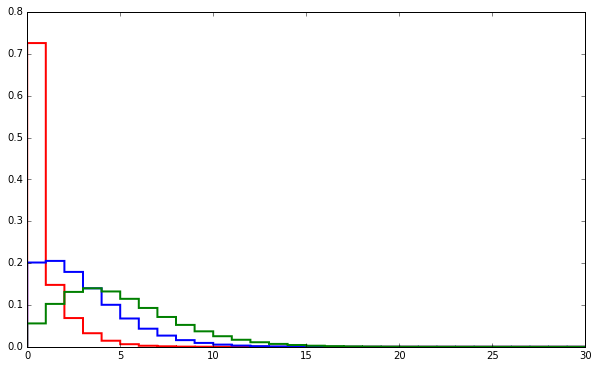

In [19]:
h_ninnings = {}
for yg in YEAR_GROUPS:
    h1 = Histogram1D("hdummy",15,0,15)
    h1.Fill(0)
    h1 = convolve(h1, hists[yg][(0,0)], 30)
    h_ninnings[yg] = {1:h1}
    for i in range(2,10):
        h_ninnings[yg][i] = convolve(h_ninnings[yg][i-1], h1, 30)

yg = (2014,2019)
plt.figure(figsize=(10,6))
h_ninnings[yg][1].Draw(opt="HIST", color='r', lw=2)
h_ninnings[yg][5].Draw(opt="HIST", color='b', lw=2)
h_ninnings[yg][9].Draw(opt="HIST", color='g', lw=2)
plt.gca().set_yscale('linear')
print [h_ninnings[yg][i].mean() for i in range(1,10)]

In [20]:
with open('../data/run_expectancies_by_nInning.pkl', 'wb') as fpk:
    pickle.dump(h_ninnings, fpk, protocol=-1)

### Further break down run expectancies by outcome of the present at-bat
* Same as first step, but further divide by outcome of at-bat
* e.g. if men on 1st and 2nd and a home run is hit, the runs scored is at least 3
So the run distribution histogram will start and peak at 3, with a tail from when more runs are eventually scored

In [11]:
main_outcomes = ["Single", "Double", "Triple", "Home Run", "Walk", "Intent Walk", 
                 "Hit By Pitch", "Field Error", "Strikeout","Other"]
def restrict(evt):
    if evt in main_outcomes:
        return evt
    return "Other"

# grab all unique game states
subset = df.query("is_last_pitch")[
    ["year", "gamePk", "inning", "half", "base_state", "outs", "event",
    "away_score", "home_score", "away_score_afterInn", "home_score_afterInn", "sdiff"]]

subset.event = subset.event.apply(restrict)
subset = subset.query("inning<9 | half=='top'")
subset = subset.query("away_score_afterInn>=away_score & home_score_afterInn>=home_score")
print subset.shape
subset.head(15)

(1079322, 12)


,year,gamePk,inning,half,base_state,outs,event,away_score,home_score,away_score_afterInn,home_score_afterInn,sdiff
2,2014,380537,1,top,0,0,Strikeout,0,0,0,0,0
7,2014,380537,1,top,0,1,Strikeout,0,0,0,0,0
12,2014,380537,1,top,0,2,Other,0,0,0,0,0
15,2014,380537,1,bottom,0,0,Strikeout,0,0,0,0,0
19,2014,380537,1,bottom,0,1,Single,0,0,0,0,0
21,2014,380537,1,bottom,1,1,Single,0,0,0,0,0
24,2014,380537,1,bottom,3,1,Other,0,0,0,0,0
28,2014,380537,1,bottom,6,2,Other,0,0,0,0,0
32,2014,380537,2,top,0,0,Walk,0,0,1,0,1
35,2014,380537,2,top,1,0,Double,0,0,1,0,1


In [21]:
group = subset.groupby(["event","base_state","outs"])
hists_evt = {}
for yg in YEAR_GROUPS:
    hists_evt[yg] = {}
    years = list(range(yg[0],yg[-1]+1))
    for g,idxs in group.groups.items():
        hists_evt[yg][g] = Histogram1D("h_{0}_{1}".format(*g), 15, 0, 15, title=";runs")
        for d in subset.loc[idxs].loc[subset.year.isin(years)].sdiff.values:
            hists_evt[yg][g].Fill(d)
        hists_evt[yg][g].Normalize()

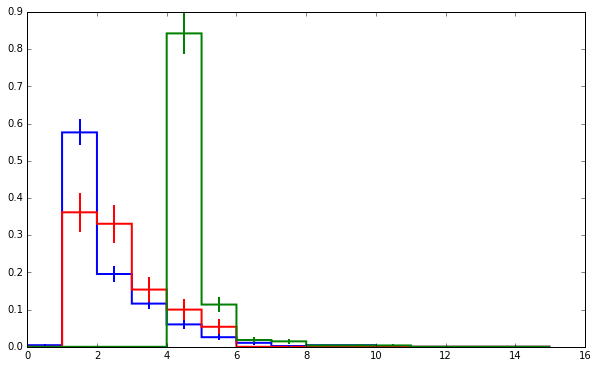

In [28]:
yg = (2014,2019)
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.set_yscale('linear')
hists_evt[yg][("Single",4,0)].Draw(fig, ax, "HIST YERR", color='b', lw=2)
hists_evt[yg][("Double",4,0)].Draw(fig, ax, "HIST YERR", color='r', lw=2)
hists_evt[yg][("Home Run",7,1)].Draw(fig, ax, "HIST YERR", color='g', lw=2)

In [69]:
with open('../data/run_expectancies_by_event.pkl', 'wb') as fpk:
    pickle.dump(hists_evt, fpk, protocol=-1)

### Now use these to get state-specific win probabilities

In [23]:
from itertools import product

win_probs = {}
for yg in YEAR_GROUPS:
    win_probs[yg] = {}
    for inning,half,base_state,outs in product(range(1,10),['top','bottom'],range(8),range(3)):
        h_thisInning = hists[yg][(base_state,outs)]
        
        nRem_home = 9-inning + (1 if half=='top' else 0)
        nRem_away = 9-inning
        
        if nRem_home > 0:
            h_remHome = h_ninnings[yg][nRem_home]
        else:
            h_remHome = Histogram1D("h_remHome", h_thisInning.nbins, 0, h_thisInning.nbins)
            h_remHome.contents[1] = 1
            
        if nRem_away > 0:
            h_remAway = h_ninnings[yg][nRem_away]
        else:
            h_remAway = Histogram1D("h_remHome", h_thisInning.nbins, 0, h_thisInning.nbins)
            h_remAway.contents[1] = 1
            
        if half=='top':
            total_away = convolve(h_thisInning, h_remAway, 30)
            total_home = h_remHome
        else:
            total_away = h_remAway
            total_home = convolve(h_thisInning, h_remHome, 30)
            
        NMAX = 25
        restOfGame_rdiff = convolve(total_home, total_away, NMAX*2+1, diff=True)
        
        win_probs[yg][(inning,half,base_state,outs)] = {"rdiff":restOfGame_rdiff}
        hp = Histogram1D("home_wprob", NMAX*2+1, -NMAX-0.5, NMAX+0.5)
        for i in range(-NMAX, NMAX+1):
            prob = 0.5*restOfGame_rdiff.contents[NMAX-i+1] + \
                   np.sum(restOfGame_rdiff.contents[NMAX-i+2:2*NMAX+2])
            hp.contents[i+NMAX+1] = prob
        win_probs[yg][(inning,half,base_state,outs)]["wprob"] = hp
        
        

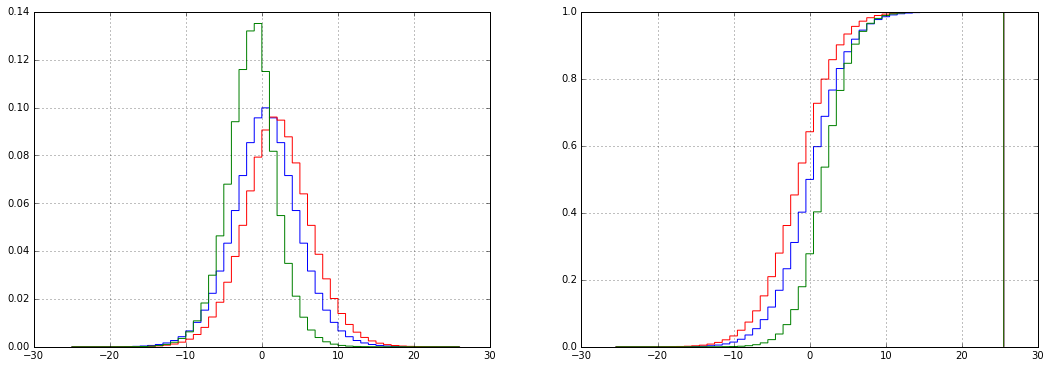

In [24]:
yg = (2014,2019)
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(121)
win_probs[yg][(1,'top',0,0)]["rdiff"].Draw(fig, ax, opt="HIST", color='b')
win_probs[yg][(1,'bottom',7,1)]["rdiff"].Draw(fig, ax, opt="HIST", color='r')
win_probs[yg][(6,'top',7,0)]["rdiff"].Draw(fig, ax, opt="HIST", color='g')
plt.gca().grid()
ax = fig.add_subplot(122)
win_probs[yg][(1,'top',0,0)]["wprob"].Draw(fig, ax, opt="HIST", color='b')
win_probs[yg][(1,'bottom',7,1)]["wprob"].Draw(fig, ax, opt="HIST", color='r')
win_probs[yg][(6,'top',7,0)]["wprob"].Draw(fig, ax, opt="HIST", color='g')
plt.gca().grid()

In [25]:
with open('../data/win_probabilities.pkl', 'wb') as fpk:
    pickle.dump(win_probs, fpk, protocol=-1)

In [62]:
subset = df[["year","balls","strikes","strike_type","event"]]
subset.event = subset.event.apply(restrict)
subset = subset.query("strikes<2 | strike_type!='F'")
vc, c = {}, {}
for yg in YEAR_GROUPS:
    years = list(range(yg[0], yg[-1]+1))
    group = subset.loc[subset.year.isin(years)]
    group = group.groupby(["balls","strikes"])
    vc[yg] = group.event.value_counts()
    c[yg] = group.event.count()

In [65]:
count_outcomes = {}
for yg in YEAR_GROUPS:
    ys = str(yg[0]) if len(yg)==1 else "{0}-{1}".format(*yg)
    count_outcomes[ys] = {}
    for balls in range(5):
        for strikes in range(4):
            if balls==4 and strikes==3:
                continue
            count_outcomes[ys]["{0}-{1}".format(balls,strikes)] = {}
            d = count_outcomes[ys]["{0}-{1}".format(balls,strikes)]

            if balls==4:
                d["Walk"] = 1.0
            elif strikes==3:
                d["Strikeout"] = 1.0
            else:
                for evt in vc[yg].loc[(balls,strikes)].index.values:
                    d[evt] = vc[yg].loc[(balls,strikes,evt)] / float(c[yg].loc[(balls,strikes)])
               
    with open("../data/count_outcomes.json", 'w') as f:
        json.dump(count_outcomes, f, indent=4, sort_keys=True, ensure_ascii=True)

In [68]:
subset.query("event=='Intent Walk' and year==2019").head(20)

,year,balls,strikes,strike_type,event
3620495,2019,0,0,B,Intent Walk
3620496,2019,1,0,B,Intent Walk
3620497,2019,2,0,B,Intent Walk
3620498,2019,3,0,B,Intent Walk
3620610,2019,0,0,B,Intent Walk
3620611,2019,1,0,B,Intent Walk
3620612,2019,2,0,B,Intent Walk
3620613,2019,3,0,B,Intent Walk
3624126,2019,0,0,B,Intent Walk
3624127,2019,1,0,B,Intent Walk
